Importing all libraries required in the code for natural language processing and plotting the knowledge graph.

In [1]:
"""
This code imports various libraries and sets up the necessary environment for working with knowledge graphs and entity resolution.

The imported libraries and their purposes are as follows:
- numpy: Provides support for mathematical operations on arrays and matrices.
- re: Provides support for regular expressions.
- pandas: Provides data manipulation and analysis tools.
- bs4: Provides tools for web scraping and parsing HTML.
- requests: Allows sending HTTP requests.
- spacy: A natural language processing library.
- xlrd: Allows reading data from Excel files.
- networkx: Provides tools for working with graphs and networks.
- matplotlib: A plotting library for creating visualizations.
- tqdm: Provides a progress bar for loops.
- nltk: A natural language processing library.
"""

import numpy as np
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
import xlrd
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span
from string import punctuation

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk import word_tokenize, pos_tag

from collections import Counter
import math

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bristi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/bristi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/bristi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


As the text in paragraphs contains pronouns in place of nouns sometimes, these pronouns need to be appropriately replaced with corresponding nouns to avoid ambiguity. For this purpose, features of natural language processing can be used.
The getTagsForWords(text) function is defined to label all words present in the Sentence as nouns, pronouns, verb, etc. The Sentence is broken down using word_tokenize() and each token is given a label (tag) using pos_tag which is then returned.
The getNounPositions function is used to create a dictionary of nouns present in the Sentence with the noun as the key and its position as the value. An item is added to the dictionary when a noun is recognised upon traversal and its position is found in the string and stored as the value of that noun.
Similarly, the pronouns and their positions are stored and returned as another dictionary.
The getNearestPreviousNoun() function is used to find the nearest noun occuring in a Sentence before the pronoun occurs. The difference in the position of each noun and a particular pronoun is calculated and accordingly the nearest noun is chosen and assigned to the variable nearKey. As there is a possibility that the pronoun occurs at the beginning of a Sentence, the nearKey can be empty. Thus, the previous Sentence in the paragraph which is also passed as an argument to the function is inspected for nouns. If the previous Sentence contains the topic of the paragraph (assumed to the most frequently referred object in the text), then nearKey is assigned that value. Otherwise, the first noun of the previous Sentence is the noun that is used for replacement.
Once the noun is received, it replaces the pronoun in the Sentence using the user-defined function pronounReplaceWithNearNoun().

In [2]:
################################ Replace Pronoun with their Proper Noun ###########################

def getTagsForWords(text):
    tokens=word_tokenize(text)
    tagged=pos_tag(tokens)
    return(tagged)

#Identify the noun position
def getNounPositions(tagged,text):      #def getNounPositions(type,tagged,text):
    nounPosi={}
    for item in tagged:
        if (item[1]=='NN' or item[1]=='NNS'):       #if item[1]==type:
            nounPosi[item[0]]=-1

    for key in nounPosi.keys():
        regExpression=r'\b'+key.lower()+r'\b'
        nounsi=[m.start() for m in re.finditer(regExpression, text.lower())]
        #print(key,nounsi)
        nounPosi[key]=nounsi
    return nounPosi

#Identify the pronoun position
def getProNounPositions(tagged,text):
    proNounPosi={}
    for item in tagged:
        if item[1]=='PRP': #or item[1]=='PRP$':
            proNounPosi[item[0].lower()]=-1

    for key in proNounPosi.keys():
        regExpression=r'\b'+key.lower()+r'\b'
        pronounsi=[m.start() for m in re.finditer(regExpression, text.lower())]
#        print(key,pronounsi)
        proNounPosi[key]=pronounsi
    return proNounPosi

#Obtain nearest previous noun
def getNearestPreviousNoun(NNP,posiOfPronoun, text, *args):
#    print('\t',NNP)
    minimumDiff=len(text)
    nearKey=''
    for keyNNP in NNP.keys():
        for posNoun in NNP[keyNNP]:
            if(posiOfPronoun>posNoun):
#                print('\t',posiOfPronoun-posNoun)
                if(minimumDiff>(posiOfPronoun-posNoun)):
                    minimumDiff=posiOfPronoun-posNoun
                    nearKey=keyNNP
    if nearKey=='':
        if (args[0]):
            previoustagged = getTagsForWords(args[0])
            previousNNP = getNounPositions(previoustagged, args[0])
            keyspreviousNNP = list(previousNNP.keys())
            #print(keyspreviousNNP)
            if (args[1].lower() in keyspreviousNNP):
                nearKey = args[1]
            else:
                nearKey = keyspreviousNNP[0]
#    print('\t near key=',nearKey)
    return nearKey

#Replace pronoun by noun
def pronounReplaceWithNearNoun(text,PRP,NNP, *args):
    replacePRP=[]
    for key in PRP.keys():
        for pos in PRP[key]:
            if (args[0]):
                nearNoun=getNearestPreviousNoun(NNP,pos,text,args[0],args[1])
            else:
                nearNoun=getNearestPreviousNoun(NNP,pos,text)
            replacePRP.append((key,pos,nearNoun))

    replacePRP=sorted(replacePRP,key=lambda x:(-x[1],x[0],x[2]))
    lineInReplacePronn=text
    for prpRep in replacePRP:
        lineInReplacePronn=lineInReplacePronn[:prpRep[1]]+prpRep[2]+lineInReplacePronn[prpRep[1]+len(prpRep[0]):]
    return lineInReplacePronn

A .csv file is opened using Pandas library function read_csv() in which the text to be processed has been stored Sentence-wise where each Sentence can be accessed iteratively by the 'Sentence' field. For each Sentence, pronoun replacement with noun is done using previously defined functions.

In [5]:
candidate_sentences = pd.read_csv("sustainable_cities_sentences.csv")
candidate_sentences.shape
candidate_sentences['Sentence']


for i in range(len(candidate_sentences)):
    firstSentence = candidate_sentences['Sentence'][0]
    firstNNP = getNounPositions(getTagsForWords(firstSentence), firstSentence)
    firstNNPkeys = list(firstNNP.keys())
    previousSentence = ''
    test = candidate_sentences['Sentence'][i]
    print (test)
    tagged = getTagsForWords(test)
    #print (tagged)
    NNP = getNounPositions(tagged, test)         #NNP = getNounPositions('NN',tagged,test)
    PRP = getProNounPositions(tagged, test)
    if i>0:
        previousSentence = candidate_sentences['Sentence'][i-1]
        textReplacedPronounByNoun = pronounReplaceWithNearNoun(test, PRP, NNP, previousSentence, firstNNPkeys[0])
    else:
        textReplacedPronounByNoun = pronounReplaceWithNearNoun(test, PRP, NNP, '')
    #print("-->",textReplacedPronounByNoun)
    candidate_sentences['Sentence'][i] = textReplacedPronounByNoun
    #lst_summarized_replaced.append(summarize_text(textReplacedPronounByNoun))

print (candidate_sentences)

Sustainable cities actively prioritize environmental, social, and economic sustainability in their development and operations.
Urban planning in sustainable cities rigorously focuses on reducing carbon footprints, enhancing lush green spaces, and promoting rich biodiversity.
Renewable energy sources, such as solar and wind power, are crucially integral to the energy strategy of sustainable cities.
Public transportation systems in sustainable cities are strategically designed to be efficient, widely accessible, and significantly reduce reliance on private vehicles.
Waste management in sustainable cities involves innovative recycling, composting, and waste-to-energy processes that are environmentally conscious.
Sustainable cities invest in robust green infrastructure, including parks, green roofs, and rain gardens, to dramatically improve air quality and provide recreational spaces.
Community engagement and participatory governance are fundamentally key to the successful implementation o

Example for processing a sentence

In [6]:
doc = nlp("Sustainable cities prioritize environmental, social, and economic sustainability in their development and operations.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Sustainable ... amod
cities ... nsubj
prioritize ... ROOT
environmental ... amod
, ... punct
social ... conj
, ... punct
and ... cc
economic ... conj
sustainability ... dobj
in ... prep
their ... poss
development ... pobj
and ... cc
operations ... conj
. ... punct


The get_entities() function is used to extract the two entities present in each sentence which will act as nodes in the knowledge graph. Both of them will be associated with either nsubj (subject) or dobj (object) as determined using       tok.dep_ (dependency tag) by the above method. As sometimes nsubj and dobj cannot individually give us the desired entity, they need to be extracted along with other terms given by the rule - extract the subject/object along with its modifiers, compound words and also extract the punctuation marks between them.Once both entities are processed, they are returned as a list. Explanation of the code:

Chunk 1:
prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

Chunk 2:
Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).
As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

Chunk 3:
Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

Chunk 4:
Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

Chunk 5:
Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

In [7]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [9]:
entity_pairs = []

for i in tqdm(candidate_sentences["Sentence"]):
  entity_pairs.append(get_entities(i))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 127.16it/s]


In [ ]:
entity_pairs

[['Sustainable  cities', 'environmental  development'],
 ['Urban  planning', 'green carbon biodiversity'],
 ['Renewable energy sources', 'sustainable energy cities'],
 ['Public transportation systems', 'private  vehicles'],
 ['Waste management', 'waste  energy'],
 ['Sustainable  cities', 'recreational air spaces'],
 ['Community engagement', 'urban sustainability areas'],
 ['urban  development', 'sustainable  construction'],
 ['Water conservation measures', 'sustainable water cities'],
 ['Sustainable  cities', 'inclusive  residents']]

To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes. To extract the relation, we have to find the ROOT of the sentence (which is also the verb of the sentence). Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word.

In [10]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object
  matcher = Matcher(nlp.vocab)

  #define the pattern
  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1", [pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

In [12]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['Sentence'])]

100%|██████████| 10/10 [00:00<00:00, 148.11it/s]


As observed in some cases, the code fails to find either of the two entities and consequently returns an empty string. To overcome this, simple looping statements are used to eliminate such relations from the knowledge graph.
Furthermore, all information is stored in a haphazard manner in different lists which is very inconvenient. Thus, to store all data related to a knowledge graph in a single place, a list of dictionaries is made. Each dictionary in the list represents a relation with keys entity1, entity2, relation and relation type.
In relation type, they are classified as one-one, one-many, many-one and many-many. For this, the pos_tag() function of nltk library is used which labels all words as singular noun (NN), plural noun (NNS), verb (VB/VBZ), etc. Based on this, if the first object is singular and second one is also singular, then it can be assumed that it is a one-to-one relation. Similarly, conditions are written for all other types of relations.

In [13]:
ep = entity_pairs.copy()
r = relations.copy()
i = 0
l = len(ep)
while i<l:
    if ep[i][0]=='' or ep[i][1]=='':
        del ep[i]
        del r[i]
        l = len(ep)
    else:
        i = i + 1

er_info = []
for i in range(len(ep)):
    er_dict = {}
    er_dict["entity1"] = ep[i][0]
    er_dict["entity2"] = ep[i][1]
    er_dict["relation"] = r[i]
    er_info.append(er_dict)
    first_ent = nltk.pos_tag([ep[i][0]])
    second_ent = nltk.pos_tag([ep[i][1]])
    #print (i, first_ent, second_ent)
    if first_ent[0][1]=="NN" and second_ent[0][1]=="NN":
        er_dict["relation type"] = "one-one"
    elif first_ent[0][1]=="NN" and second_ent[0][1]=="NNS":
        er_dict["relation type"] = "one-many"
    elif first_ent[0][1]=="NNS" and second_ent[0][1]=="NN":
        er_dict["relation type"] = "many-one"
    elif first_ent[0][1]=="NNS" and second_ent[0][1]=="NNS":
        er_dict["relation type"] = "many-many"
    else:
        er_dict["relation type"] = "undefined"


print (er_info)

[{'entity1': 'Sustainable  cities', 'entity2': 'environmental  development', 'relation': 'prioritize environmental', 'relation type': 'many-one'}, {'entity1': 'Urban  planning', 'entity2': 'rich carbon biodiversity', 'relation': 'focuses on', 'relation type': 'undefined'}, {'entity1': 'Renewable energy sources', 'entity2': 'sustainable energy cities', 'relation': 'are', 'relation type': 'many-many'}, {'entity1': 'Public transportation systems', 'entity2': 'private  vehicles', 'relation': 'designed', 'relation type': 'many-many'}, {'entity1': 'waste  that', 'entity2': 'waste  energy', 'relation': 'involves innovative', 'relation type': 'undefined'}, {'entity1': 'Sustainable  cities', 'entity2': 'recreational air spaces', 'relation': 'invest in robust', 'relation type': 'many-many'}, {'entity1': 'Community engagement', 'entity2': 'urban sustainability areas', 'relation': 'are', 'relation type': 'one-many'}, {'entity1': 'urban  development', 'entity2': 'maximum  efficiency', 'relation': '

The dictionary er_info created is being stored in a text file format.

In [14]:
dictfile = open('sustainable_cities2.txt', 'w')
dictfile.write("SNO, Entity1, Entity2, Relation, Relation Type\n")
for i in range(len(er_info)):
    dictfile.write(str(i+1) + ", " + er_info[i]["entity1"] + ", " + er_info[i]["entity2"] + ", " + er_info[i]["relation"] + ", " + er_info[i]["relation type"] + "\n")
dictfile.close()

Now, to plot the knowledge graph, all the information extracted is stored as a pandas dataframe for easy use.

In [18]:
# extract subject
source = [i[0] for i in ep]

# extract object
target = [i[1] for i in ep]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':r})

Next, networkx library is used to create a network from this dataframe which is going to be a directed graph.

In [19]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

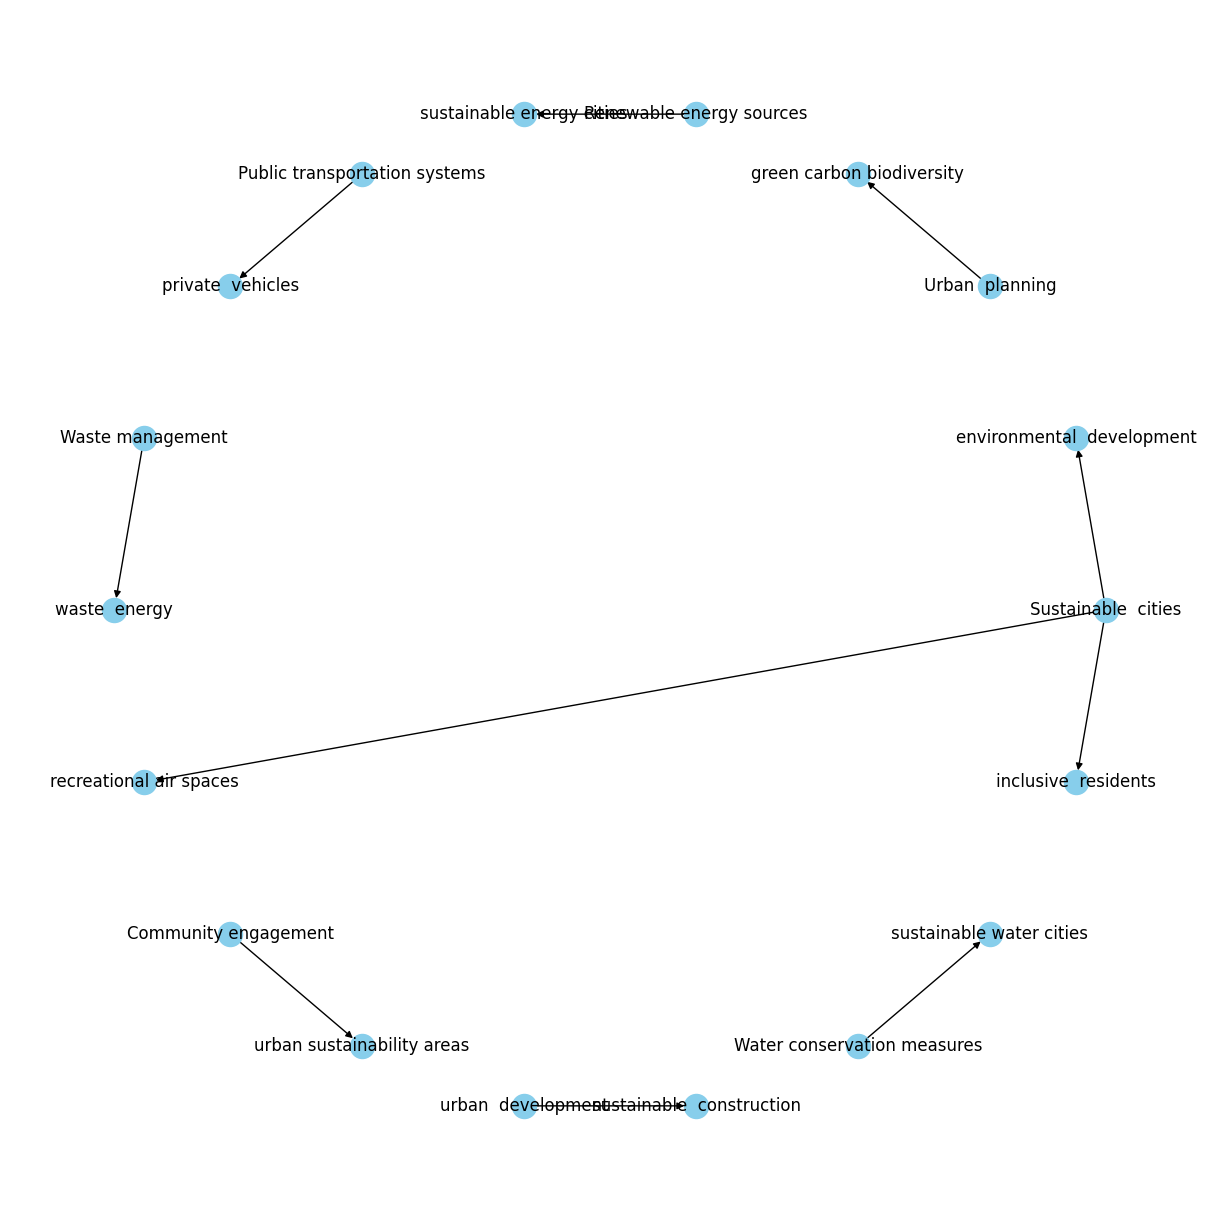

In [20]:
plt.figure(figsize=(12,12))

pos = nx.circular_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Different layouts of graphs are experimented with to find the best fit for the given text.

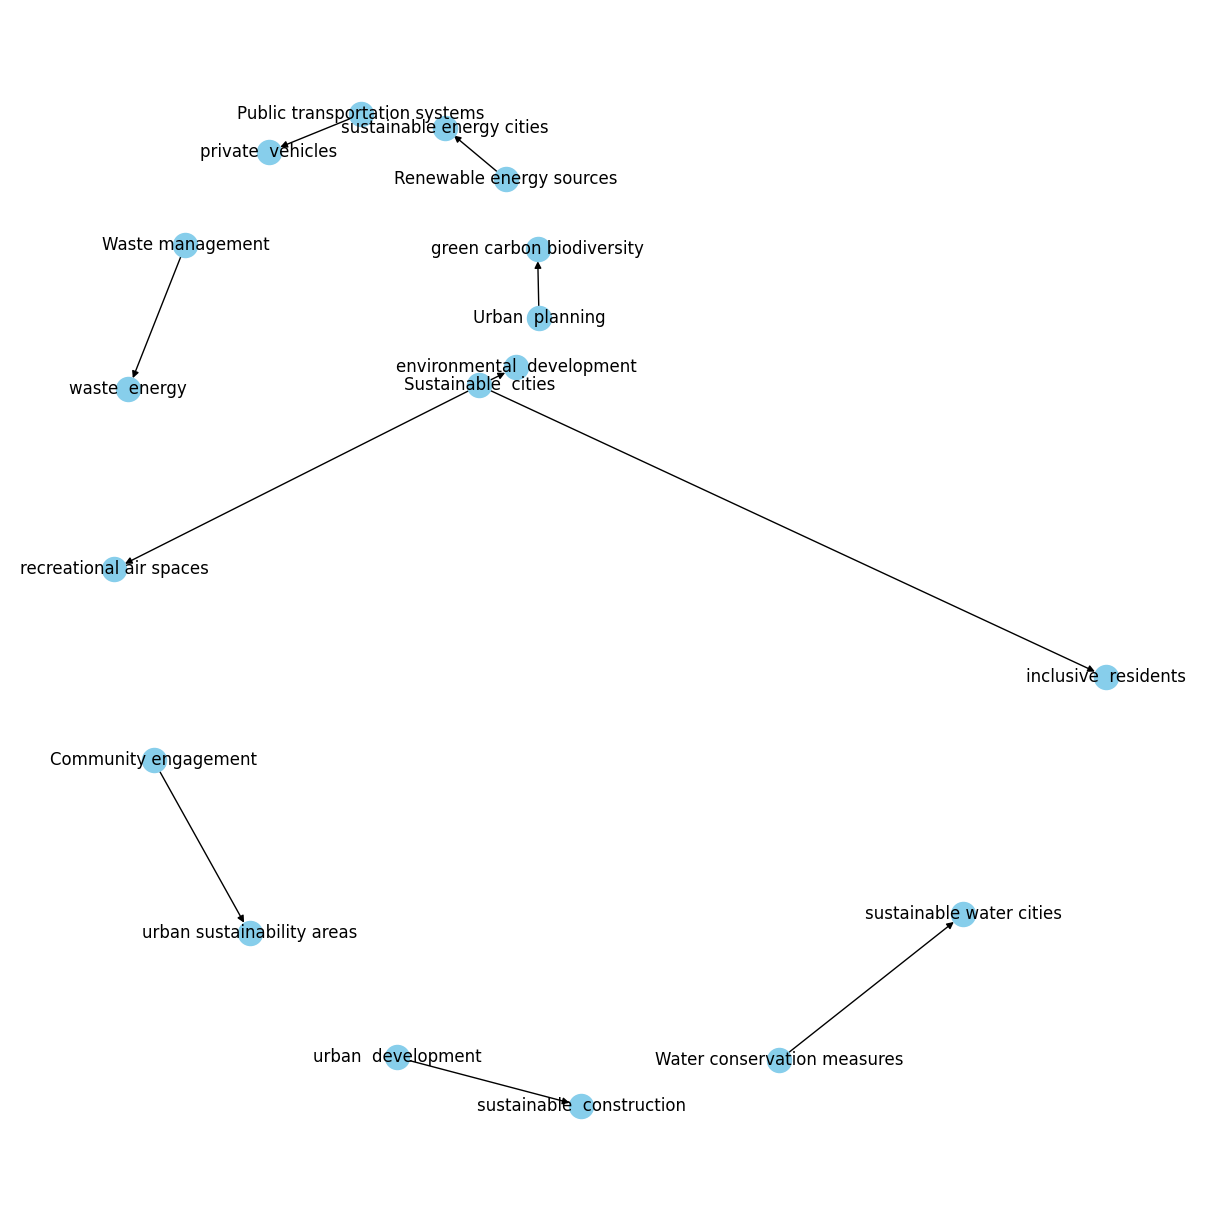

In [21]:
plt.figure(figsize=(12,12))

pos = nx.spiral_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

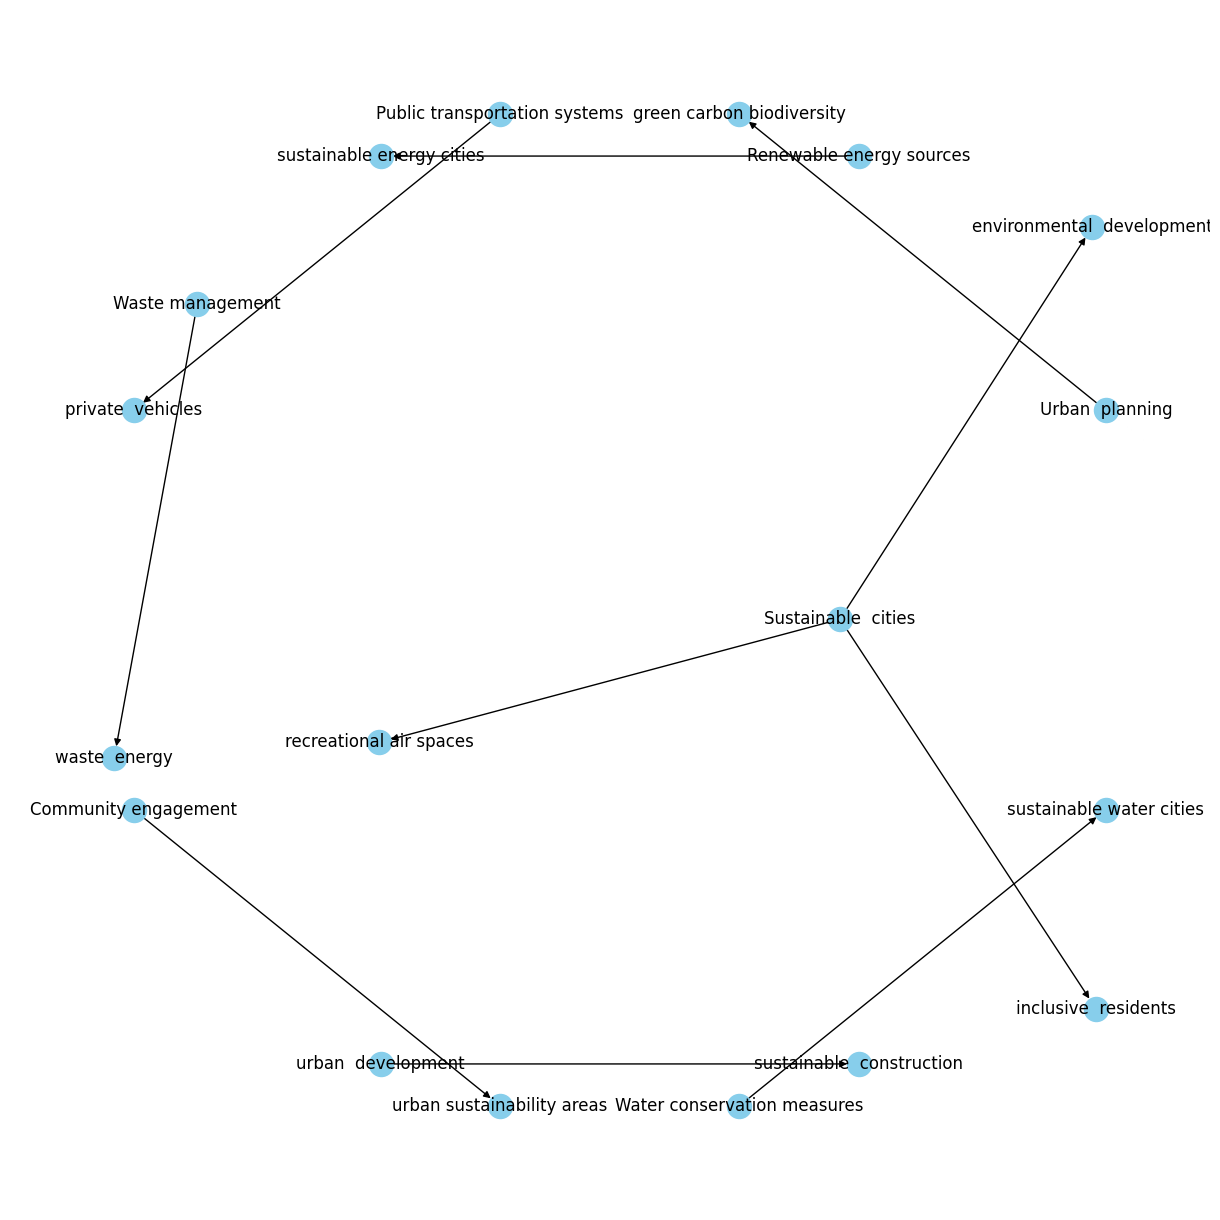

In [22]:
plt.figure(figsize=(12,12))

pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

As the edges don't specify which relation holds the entities together, the relations are added as labels to the edges.

In [23]:
# extract subject
source = [i[0] for i in ep]

# extract object
target = [i[1] for i in ep]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':r})

label={}
for i in range(len(source)):
    label[(source[i],target[i])]=r[i]

In [24]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())


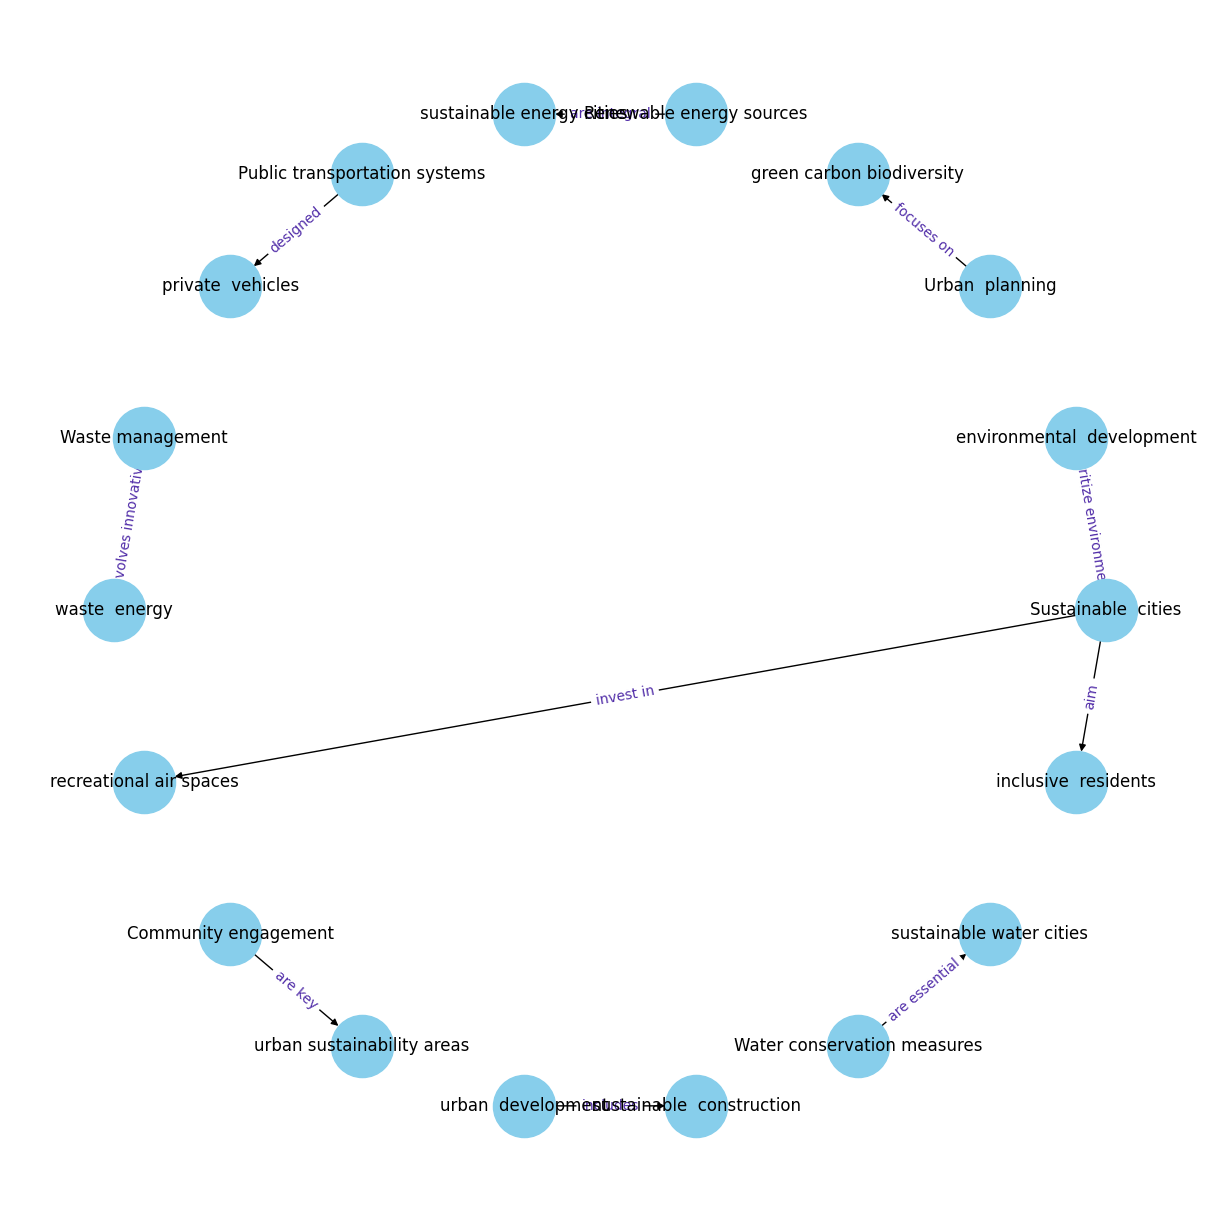

In [25]:
plt.figure(figsize=(12,12))

pos = nx.circular_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, edge_cmap=plt.cm.Blues, pos = pos)

nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=label,
    font_color='#512da8'
)
plt.show()

Python to Isabelle/HOL code conversion:
A file with t.thy extension is opened in write mode which can be opened and executed in Isabelle/HOL. All the general definitions such as those for one-to-many relations, many-to-many relations and so on are written onto the file. After this, using the 'entity1' and 'entity2' keys of the er_info dictionary, a list of all entities is created and converted to a set to get unique elements. These entities are then defined in Isabelle/HOL. Similarly, relations are also defined one-by-one.
After the entities and relations have been specified, all axioms related to ISA relation are written to the file based on whether any relation present in the dictionary is of the form 'is'. After this, comparing the 'relation type' key of the er_info dictionary, all axioms related to one-one, one-many, etc. relations are written to the file.
Finally, a code to check if the model created is successful in Isabelle/HOL is added to the file.

In [27]:
boolarr = [False for i in ep]
file = open('sustainable_cities.thy', 'w')
file.write("theory sustainable_cities imports Main\n")
file.write("begin \n\n")
file.write("typedecl i\n")
file.write("type_synonym entity = \"i\<Rightarrow>bool\"\n")
file.write("type_synonym relation = \"i \<Rightarrow> i \<Rightarrow> bool\"\n\n")
#ISA Axiom   #MAKE CHANGES
file.write("definition ISA :: \"entity \<Rightarrow> entity \<Rightarrow> bool\" (\"_ is _\") where\n\"Entity1 is Entity2 \<equiv> (\<forall>z. Entity1 z \<longrightarrow> Entity2 z)\" \n\n")
# General definitions
file.write("\ndefinition disjoint :: \"entity \<Rightarrow> entity \<Rightarrow> bool\" where \n    \"disjoint C1 C2 \<equiv> \<not>(\<exists>x::i. C1 x \<and> C2 x)\"\n")
file.write("\ndefinition conv_rel :: \"relation \<Rightarrow> relation\" where \n   \"conv_rel Rel \<equiv> (\<lambda>x y. Rel y x)\"\n")
file.write("\ndefinition is_empty_rel :: \"relation \<Rightarrow> bool\" where \n   \"is_empty_rel Rel \<equiv> (\<forall>x y. \<not>Rel x y)\"\n")
# One-to-many Relation Axiom
file.write("\ndefinition one_to_n_rel :: \"entity \<Rightarrow> entity \<Rightarrow> relation \<Rightarrow> bool\" where \n    \"one_to_n_rel E1 E2 Rel \<equiv> \n    ((\<exists>x. E1 x) \<and> (\<forall>x. E1 x \<longrightarrow> (\<exists>y. E2 y \<and> Rel x y)))\n    \<and>\n    (\<forall>x y. Rel x y \<longrightarrow> ((E1 x \<and> E2 y)))\"\n")
# Many-to-one Relation Axiom
file.write("\ndefinition n_to_one_rel :: \"entity \<Rightarrow> entity \<Rightarrow> relation \<Rightarrow> bool\" where\n    \"n_to_one_rel E1 E2 Rel \<equiv> one_to_n_rel E2 E1 (conv_rel Rel)\"\n")
# Many-to-many Relation Axiom
file.write("\ndefinition n_to_m_rel :: \"entity \<Rightarrow> entity \<Rightarrow> relation \<Rightarrow> bool\" where\n    \"n_to_m_rel E1 E2 Rel \<equiv> one_to_n_rel E1 E2 Rel \<and> n_to_one_rel E1 E2 Rel\"\n")
# One-to-one Relation Axiom
file.write("\ndefinition one_to_one_rel :: \"entity \<Rightarrow> entity \<Rightarrow> relation \<Rightarrow> bool\" where\n   \"one_to_one_rel E1 E2 Rel \<equiv> \n    n_to_m_rel E1 E2 Rel \n    \<and> (\<forall>x y z. (Rel x y \<and> Rel x z) \<longrightarrow> y = z)\n    \<and> (\<forall>x y z. (Rel x y \<and> Rel z y) \<longrightarrow> x = z)\"\n")

file.write("\nconsts\n")
file.write("  (*Entities*)\n")
entities = []
for i in range (len(er_info)):
    entities.append(er_info[i]['entity1'])
    entities.append(er_info[i]['entity2'])
entities = list(set(entities))
for i in range (len(entities)):
    entities[i] = entities[i].replace(" ", "_")
for i in range (len(entities)):
    file.write("  " + entities[i] + " :: entity\n")
file.write("  (*Relations*)\n")
er_relations = []
for i in range (len(er_info)):
    er_relations.append(er_info[i]['relation'])
relations_1 = list(set(er_relations))
for i in range (len(relations_1)):
    file.write("  " + relations_1[i].capitalize().replace(" ", "_") + " :: relation (\"_ " + relations_1[i].replace(" ", "-") + " _\")\n")
#file.write("\naxiomatization where \n")
#for i in range (len(r)):
#    n = str(i+1)
#    file.write("A" + n + ": \"" + ep[i][0].replace(" ", "_") + " " + r[i].replace(" ", "-") + " " + ep[i][1].replace(" ", "_") + "\" ")
#    if (i<len(r)-1):
#        file.write("and \n")
#ISA Relation
isa_rel = []
for i in range (len(er_info)):
    if er_info[i]['relation']=="is":
        isa_rel.append(er_info[i])
        boolarr[i] = True
file.write("\n\naxiomatization where\n")
for i in range(len(isa_rel)):
    n=str(i+1)
    file.write("ISA" + n + ": \" ISA " + isa_rel[i]['entity1'].replace(" ", "_") + " " + isa_rel[i]['entity2'].replace(" ", "_") + "\" ")
    if (i<len(isa_rel)-1):
        file.write("and \n")
#Other relations
file.write("\n")
for i in range(len(er_info)):
    if (boolarr[i]==False):
        if er_info[i]['relation type']=="one-one":
            boolarr[i] = True
            file.write("\naxiomatization where\none_to_one" + str(i) + ": \"one_to_one_rel " + er_info[i]['entity1'].replace(" ", "_") + " " + er_info[i]['entity2'].replace(" ", "_") + " " + er_info[i]['relation'].capitalize().replace(" ", "_") + "\" ")
        elif er_info[i]['relation type']=="one-many":
            boolarr[i] = True
            file.write("\naxiomatization where\none_to_many" + str(i) + ": \"one_to_n_rel " + er_info[i]['entity1'].replace(" ", "_") + " " + er_info[i]['entity2'].replace(" ", "_") + " " + er_info[i]['relation'].capitalize().replace(" ", "_") + "\" ")
        elif er_info[i]['relation type']=="many-one":
            boolarr[i] = True
            file.write("\naxiomatization where\nmany_to_one" + str(i) + ": \"n_to_one_rel " + er_info[i]['entity2'].replace(" ", "_") + " " + er_info[i]['entity1'].replace(" ", "_") + " " + er_info[i]['relation'].capitalize().replace(" ", "_") + "\" ")
        elif er_info[i]['relation type']=="many-many":
            boolarr[i] = True
            file.write("\naxiomatization where\nmany_to_many" + str(i) + ": \"n_to_m_rel " + er_info[i]['entity1'].replace(" ", "_") + " " + er_info[i]['entity2'].replace(" ", "_") + " " + er_info[i]['relation'].capitalize().replace(" ", "_") + "\" ")
#Checking Output
file.write("\n\n(*Consistency*) \n")
file.write("lemma True nitpick[satisfy,user_axioms,show_all,format=3] oops (*Model found*)\n\n")
file.write("end\n")
file.close()